In [131]:
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import graphviz as gr
import numpy as np
import seaborn as sns
from sklearn.preprocessing import scale

# 1.

From the Howell1 dataset, consider only the people younger than 13 years
old. Estimate the causal association between age and weight. Assume that
age influences weight through two paths. First, age influences height, and
height influences weight. Second, age directly influences weight through agerelated changes in muscle growth and body proportions.

In [113]:
data = pd.read_csv('../Data/Howell1.csv', delimiter=';')
data = data[data['age']<13]
data.describe()

,height,weight,age,male
count,146.000000,146.000000,146.000000,146.000000
mean,98.810729,14.693328,5.401370,0.486301
std,21.489527,5.722741,3.824657,0.501533
min,53.975000,4.252425,0.000000,0.000000
25%,84.455000,10.829509,2.000000,0.000000
50%,98.844100,13.792032,5.000000,0.000000
75%,114.300000,18.335039,8.000000,1.000000
max,147.955000,32.488527,12.000000,1.000000


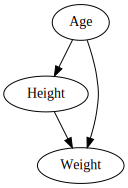

In [97]:
G = gr.Digraph()
G.edge('Age', 'Height')
G.edge('Height', 'Weight')
G.edge('Age', 'Weight')
G

In [248]:
def dgp(age: int):
    height = 10 + age*10 + np.random.normal(0,5)
    weight = 5 + 0.2*height + 0.1*age + np.random.normal(0,5)
    return height, weight

dgp(13)

(138.09190026473945, 31.034163521481872)

In [250]:
ages = [4, 5, 10, 13]
N = 50
gen_data = []
for age in ages:
    for n in range(N):
        h, w = dgp(age)
        d = {
            'age': age,
            'height': h,
            'weight': w,
        }
        gen_data.append(d)
gen_data = pd.DataFrame(gen_data)
gen_data

,age,height,weight
0,4,47.275218,13.132406
1,4,40.992193,11.927842
2,4,40.255750,17.153018
3,4,40.319791,15.066676
4,4,53.357622,12.214189
...,...,...,...
195,13,135.190722,26.704362
196,13,140.203768,33.067435
197,13,150.633775,31.300106
198,13,136.343728,40.718283


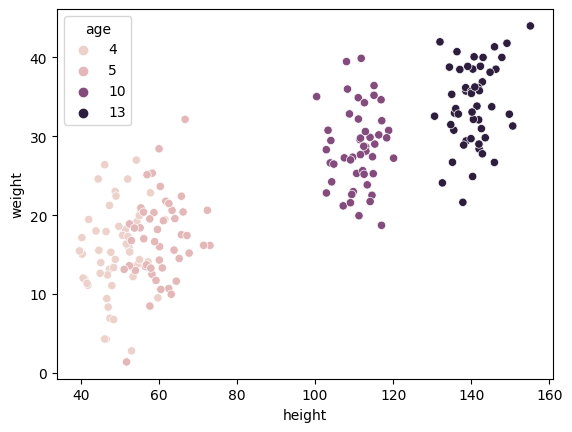

In [251]:
sns.scatterplot(data=gen_data, x='height', y='weight', hue='age');

# 2

Use a linear regression to estimate the total causal effect of each year of growth on weight

In [90]:
data = pd.read_csv('../Data/Howell1.csv', delimiter=';')
data = data[data['age']<13]
data.loc[:, ['height', 'weight', 'age']] = scale(data.loc[:, ['height', 'weight', 'age']] )
data

,height,weight,age,male
18,1.079075,0.863481,1.731226,1
19,0.308150,-0.130696,0.681780,0
20,-0.581380,-0.737144,0.288238,0
24,0.486056,0.227208,0.419419,0
30,0.723264,0.555286,1.468865,1
...,...,...,...,...
531,-0.522078,-0.707319,0.157057,0
535,0.752915,0.495635,0.419419,1
536,-1.441259,-1.308796,-1.154750,0
538,-1.026145,-1.169611,-1.154750,1


In [239]:
with pm.Model() as model:
    age_data = pm.ConstantData(name='age_data', value=gen_data['age'])
#     height_data = pm.ConstantData(name='height_data', value=data['height'])
    weight_data = pm.ConstantData(name='weight_data',value=gen_data['weight'])
    
#     beta_h_a = pm.Uniform('beta_h_a',0, 10)
#     alpha_h = pm.Normal('alpha_h',0, 10)
#     sigma_h = pm.Uniform('sigma_h',0, 10)
#     mu_h = pm.Deterministic('mu_h', alpha_h + beta_h_a*age_data)
#     height = pm.Normal('height', mu_h, sigma_h, observed=height_data)
    
    beta_w_a = pm.Uniform('beta_w_a',0, 10)
    alpha_w = pm.Normal('alpha_w',0, 10)
    sigma_w = pm.Uniform('sigma_w',0, 10)
#     mu_w = pm.Deterministic('mu_w', alpha_w + beta_w_a*age_data + beta_w_h*height_data)

    mu_w = pm.Deterministic('mu_w', alpha_w + beta_w_a*age_data)
    weight = pm.Normal('weight', mu_w, sigma_w, observed=weight_data)

In [240]:
model

beta_w_a ~ U(0, 10)
 alpha_w ~ N(0, 10)
 sigma_w ~ U(0, 10)
    mu_w ~ Deterministic(f(alpha_w, beta_w_a))
  weight ~ N(mu_w, sigma_w)

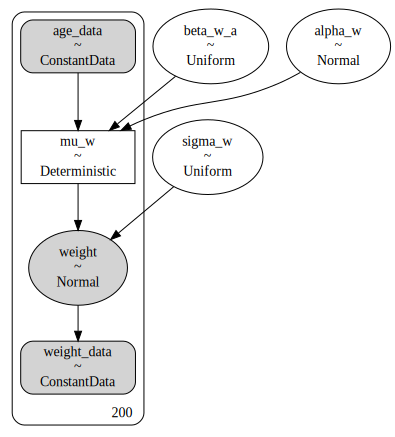

In [241]:
pm.model_to_graphviz(model)

In [242]:
with model:
    samples = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_w_a, alpha_w, sigma_w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


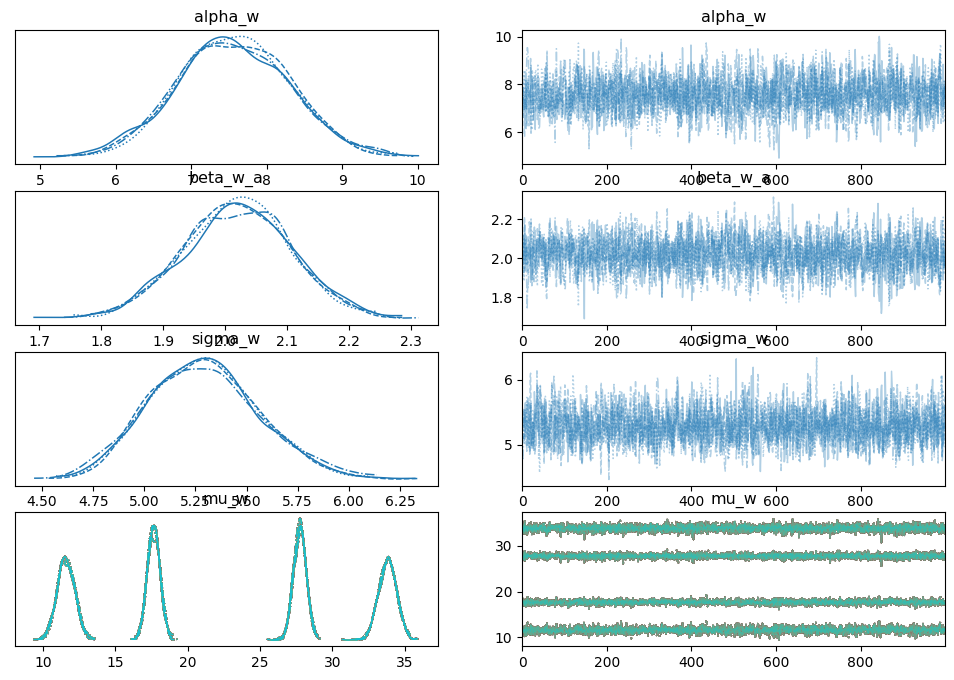

In [243]:
az.plot_trace(samples);

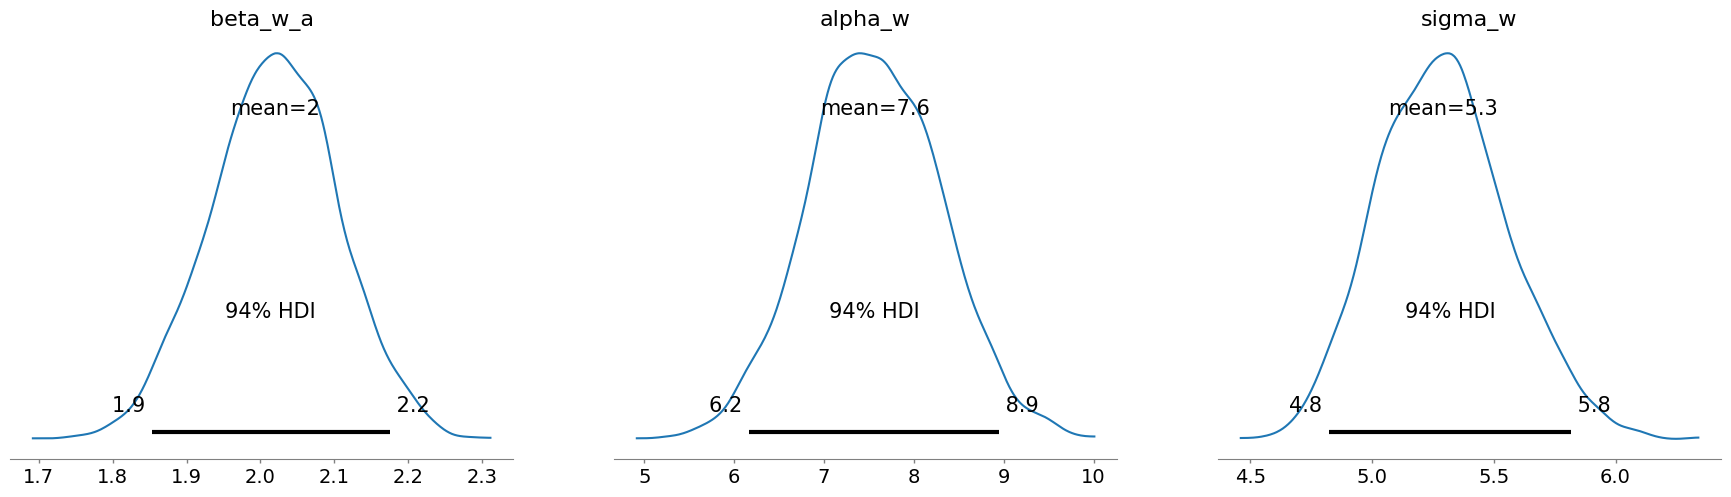

In [244]:
az.plot_posterior(samples, var_names=['beta_w_a', 'alpha_w', 'sigma_w']);

In [245]:
#Simulating lines from prior
with model:
    pm.sample_posterior_predictive(samples, extend_inferencedata=True)

Sampling: [weight]


<AxesSubplot: xlabel='weight / weight'>

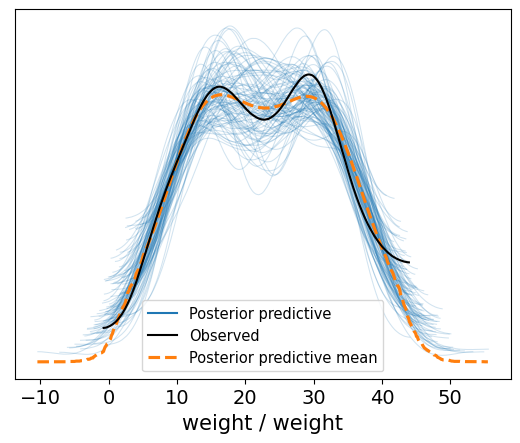

In [246]:
az.plot_ppc(samples, num_pp_samples=100)

In [247]:
az.summary(samples, var_names=['beta_w_a', 'alpha_w', 'sigma_w'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_w_a,2.019,0.086,1.853,2.175,0.002,0.001,1927.0,2113.0,1.0
alpha_w,7.567,0.740,6.169,8.944,0.017,0.012,1867.0,1817.0,1.0
sigma_w,5.292,0.268,4.822,5.817,0.006,0.004,2266.0,2006.0,1.0


# 3

Now suppose the causal association between age and weight might be different for boys and girls. Use a single linear regression, with a categorical
variable for sex, to estimate the total causal effect of age on weight separately
for boys and girls. How do girls and boys differ? Provide one or more posterior contrasts as a summarym

# 4

The data in data(Oxboys) (rethinking
package) are growth records for 26 boys measured over 9 periods. I want
you to model their growth. Specifically, model the increments in growth
from one period (Occasion in the data table) to the next. Each increment is
simply the difference between height in one occasion and height in the previous occasion. Since none of these boys shrunk during the study, all of the
growth increments are greater than zero. Estimate the posterior distribution
of these increments. Constrain the distribution so it is always positive—it
should not be possible for the model to think that boys can shrink from year
to year. Finally compute the posterior distribution of the total growth over
all 9 occasions.